In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from scipy.stats import normaltest
from scipy.stats import chi2
from scipy.stats import norm
from numpy import mean
from numpy import sqrt
import math
sns.set()

### Import data and basic stats

---

In [250]:
#Read in csv file here
df = pd.read_csv("Summary_all.csv")

In [251]:
mean_data = np.mean(df['weight_tot'])
lower_15 = mean_data * (1-.15)
upper_15 = mean_data * (1 + 0.15)

In [252]:
df['out_of_spec'] = df['weight_tot'].gt(upper_15) | df['weight_tot'].lt(lower_15)

In [253]:
(df['out_of_spec'].sum() / df.shape[0])*100

0.0013456550480567058

### Tolerance interval for normal distributions
---

In [254]:
def tolerance_interval(data, con=0.95, cov=0.95):
    """
    From https://machinelearningmastery.com/statistical-tolerance-intervals-in-machine-learning/
    From https://www.itl.nist.gov/div898/handbook/prc/section2/prc263.htm
    Calculates the 2-sided tolerance interval using Howe's method. Does not use Guenther's k2 correction.

    params: 
            data: array-like. normally distributed continuous data
            con: level of confidence to achieve. Defaults to 0.95
            cov: percent of population covered by the interval. Defaults to 0.95
    Returns:
            lower bound, upper bound
    """

    # specify degrees of freedom
    n = len(data)
    dof = n - 1
    # specify data coverage
    cov_inv = (1.0 - cov) / 2.0
    gauss_critical = norm.isf(cov_inv)
    #specify confidence
    chi_critical = chi2.isf(q=con, df=dof)
    # k_2
    k_2 = gauss_critical * sqrt((dof * (1 + (1/n))) / chi_critical)
    # summarize
    data_mean = mean(data)
    data_std = np.std(data)
    lower, upper = data_mean-(k_2*data_std), data_mean+(k_2*data_std)
    return lower, upper

### Interval Calculations
---

In [255]:
# Tolerance Interval
coverage = 0.999983 # 1 in 60000
first_quant = (1-coverage)/2
second_quant = 1. - first_quant
lower, upper = tolerance_interval(df['weight_tot'], con=0.95, cov=coverage)

# Quantile Prediction Interval
lower_quant = np.quantile(df['weight_tot'], first_quant)
upper_quant = np.quantile(df['weight_tot'], second_quant)

# Standard deviation for 5 sigma analysis
sigma = 4.5
stdev = np.std(df['weight_tot'])

### Plotting
---

In [256]:
sns.set(font_scale=1.5)

C:\Users\eric.evje\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\eric.evje\Anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


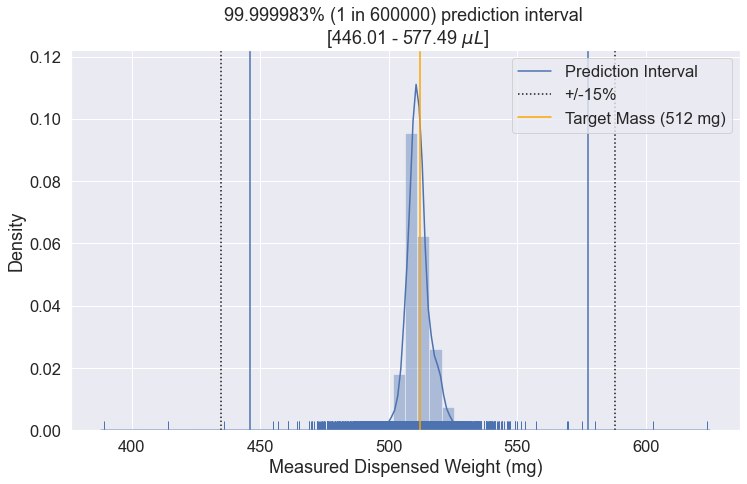

In [257]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.distplot(df['weight_tot'], rug=True)
# ax.axvline(lower, label='tol_int', color='orange')
# ax.axvline(upper, label='tol_int', color='orange')
ax.axvline(lower_quant, label='Prediction Interval')
ax.axvline(upper_quant)
ax.axvline(lower_15, label='+/-15%', color='k', linestyle=':')
ax.axvline(upper_15, color='k', linestyle=':')
ax.axvline(512, label='Target Mass (512 mg)', color='orange')
# ax.axvline(mean_data + sigma*stdev, label='{} sigma'.format(sigma), color='green')
# ax.axvline(mean_data - sigma*stdev, label='{} sigma'.format(sigma), color='green')
ax.set(title='99.999983% (1 in 600000) prediction interval \n [{:.2f} - {:.2f} $\mu L$]'.format(lower_quant, upper_quant),
      xlabel='Measured Dispensed Weight (mg)')
ax.legend()
plt.show()

### Non-parametric tolerance interval (ignore)
---

In [258]:
df['weight_tot'].min()

389.2

In [259]:
beta = 1 -.997**df.shape[0]
beta

1.0

In [260]:
len(df['weight_tot'])

297253

In [261]:
def r_s_finder(data, beta, coverage):
    N = len(data)
    for i in range(N):
        r = i + 1
        s = (N-1) - i
        B = 0
        for j in range(s - r - 1):
            factorial = math.factorial(N) / (math.factorial(j) * math.factorial(N - j))
            temp_beta = factorial * coverage**j * (1 - coverage)**(N-j)
            B += temp_beta
#             print(factorial, temp_beta, B)
#         print("######")
        if math.isclose(beta, B, abs_tol=0.005):
            return r, s
    return "bad"

In [262]:
def N_finder(N, beta, coverage):
    for i in range(N):
#         print(i)
        B = 0
        for j in range(i):
#             print(i, j)
            factorial = math.factorial(i) / (math.factorial(j) * math.factorial(i - j))
            temp_beta = factorial * coverage**j * (1 - coverage)**(i-j)
            B += temp_beta
#             print(factorial, temp_beta)
#         print(B)
#         print("####")
        if B > beta:
            return B, i

In [263]:
N_finder(df['weight_tot'].shape[0], 0.95, 0.997)

(0.9501381951037109, 998)

In [264]:
truncated_data = df.head(1000)